### 1. Define the Geometry and Physics
First, define the geometries of your domain. Then, attach the boundary conditions and the governing PDE to the geometric entities.

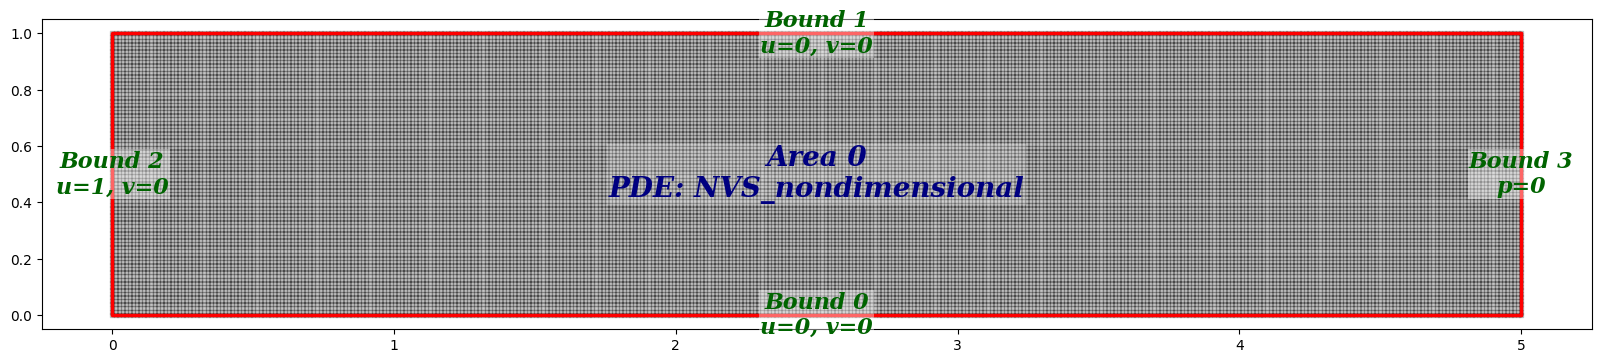

In [25]:
from deepflow import PINN, Geometry, Physics, NetworkTrainer, Evaluate, ProblemDomain

# Define the area and bounds
rectangle = Geometry.rectangle([0, 5], [0, 1])

domain = ProblemDomain(bound_list=rectangle.bound_list, area_list=[rectangle], device='cuda')

# Define the physics at the geometry
domain.bound_list[0].define_bc({'u': 0, 'v': 0})
domain.bound_list[1].define_bc({'u': 0, 'v': 0})
domain.bound_list[2].define_bc({'u': 1, 'v': 0})
domain.bound_list[3].define_bc({'p': 0})
domain.area_list[0].define_pde(Physics.NVS_nondimensional(U=0.0001, L=1, mu=0.001, rho=1000))
domain.show_setup() # Display geometry and conditions

Next, sample the initial collocation points. This will automatically create training data according to the defined physics.

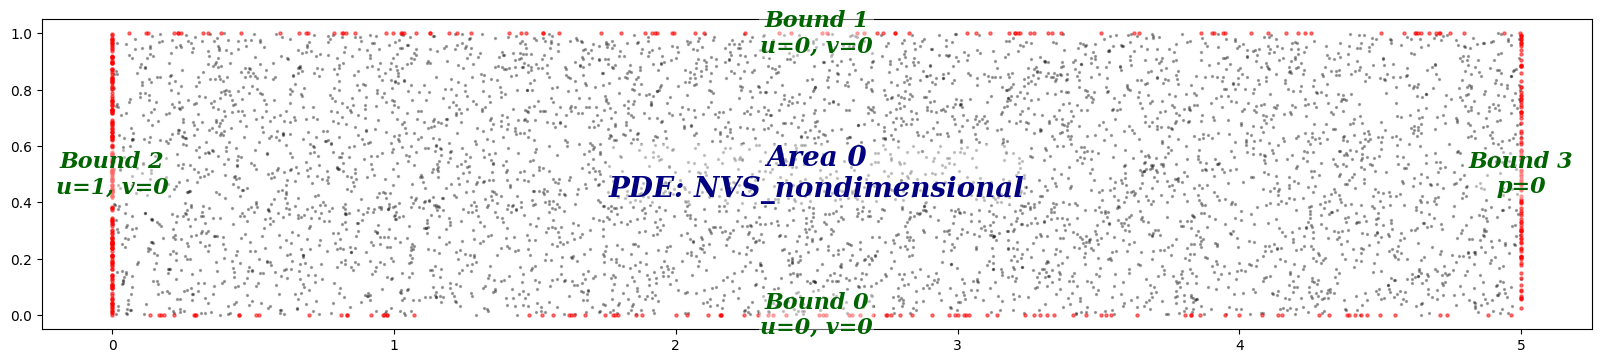

In [26]:
# Sampling initial collocation points
domain.sampling_random_r([100, 100, 200, 100], [5000])
domain.show_coordinates(display_conditions=True)  # Display collocation points

Sampling collocation points

### 2. Define the Model and Loss
Create the PINN model and a function to calculate the loss. This function handles the random sampling of points for each training step.

In [20]:
# Initialize the PINN model
model0 = PINN(width=40, length=4)

# Design the steps to calculate loss
iterations = 0
def calc_loss(model):
    global iterations
    iterations += 1

    # Add collocation points based on residual
    if iterations % 1000 == 0:
        domain.sampling_RAR([40, 40, 80, 40], [1000], model)

    # BC Loss
    bc_loss = 0.0
    for bound in domain.bound_list:
        bc_loss += bound.calc_loss(model)

    # PDE Loss
    pde_loss = 0.0
    for area in domain.area_list:
        pde_loss += area.calc_loss(model)

    # Total Loss
    total_loss = bc_loss + pde_loss

    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}  # MUST RETURN IN THIS FORMAT


### 3. Train the Model

Train the model using the Adam optimizer.

In [21]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.002,
    epochs=2000,
    print_every=250,
    thereshold_loss=0.01,
    device='cuda'
)

epoch 1, total_loss: 0.88632, bc_loss: 0.88576, pde_loss: 0.00056
epoch 251, total_loss: 0.08569, bc_loss: 0.06956, pde_loss: 0.01613
epoch 501, total_loss: 0.05331, bc_loss: 0.04426, pde_loss: 0.00905
epoch 751, total_loss: 0.04314, bc_loss: 0.03720, pde_loss: 0.00595
epoch 1001, total_loss: 0.04783, bc_loss: 0.04150, pde_loss: 0.00633
epoch 1251, total_loss: 0.03318, bc_loss: 0.02846, pde_loss: 0.00472
epoch 1501, total_loss: 0.02386, bc_loss: 0.02037, pde_loss: 0.00348
epoch 1751, total_loss: 0.01901, bc_loss: 0.01616, pde_loss: 0.00285


### 4. Visualize the Results

After training, you can easily visualize the flow field and training history.

available_data: ('u', 'v', 'p', 'velocity_magnitude', 'u_x', 'v_x', 'p_x', 'u_y', 'v_y', 'p_y', 'u_xx', 'v_xx', 'u_yy', 'v_yy', 'PDE residual', 'x', 'y', 'total_loss', 'bc_loss', 'pde_loss')


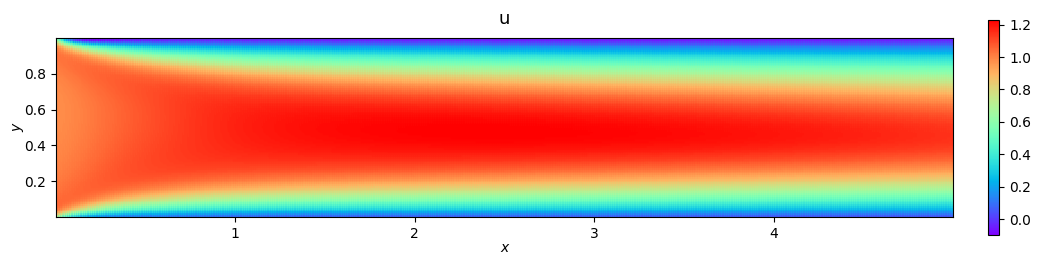

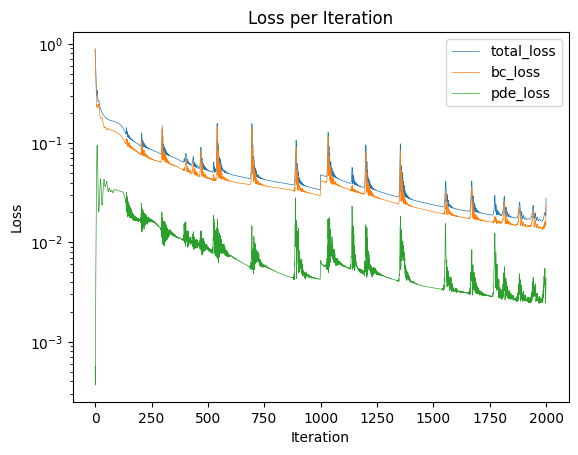

In [ ]:
import matplotlib.pyplot as plt
from deepflow.Visualize import VisualizeTemplate

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Fluid field
VisualizeTemplate.colorplot(area_eval.X, area_eval.Y, area_eval.data_dict['u'], ax1, 'u', 'rainbow', s=10)
ax1.set_aspect('equal', adjustable='box')
ax1.set_xlim(area_eval.X_min, area_eval.X_max)
ax1.set_ylim(area_eval.Y_min, area_eval.Y_max)

# Loss curve
ax2.plot(area_eval.data_dict['total_loss'], label='total_loss', linewidth=0.5)
ax2.plot(area_eval.data_dict['bc_loss'], label='bc_loss', linewidth=0.5)
ax2.plot(area_eval.data_dict['pde_loss'], label='pde_loss', linewidth=0.5)
ax2.set_yscale("log")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Loss")
ax2.set_title("Loss per Iteration")
ax2.legend()

plt.tight_layout()
plt.show()